# Hard and soft constraints

### Hard constraints
These are constraints that must be pursued during the search and without meeting these constraints, the solution is not true. These constraints are:
- Each course that the students study should be only the ones in the course list
- Professors teaching specific courses should be the ones assigned to it
- Each student group can only study one course at a time
- Each teacher can only teach one course at a time
- Each teacher can only teach in their availability times
- Each student group should study with the same amount as their weekly study hours
- Each courses should be studied with with the same amount of their assigned weekly study hours

### Soft constraints
These constraints that are not mandatory for a solution must be pursued, but the quality of the courses schedule is decided by following these constraints
- Each professor has a minimum weekly teaching hour of 1
- There should be at least one period break between four hours of lectures for student groups
- There should be at least one period break between two hours of lectures for teachers

# Initialization

In [417]:
# Libraries that will be used in the project is imported
import numpy as np
from numpy import random
from itertools import product
from prettytable import PrettyTable
import csv
import pandas as pd
import textwrap

In [418]:
# Initialization to convert input from user into a single dictionary data
# The initialization will take information of students, courses, timeslots availability, and list of professors
def initialize(students, courses, day_times, prof_input):
    initialized_data = {}
    initialized_data["stgs"] = students
    initialized_data["courses"] = courses
    initialized_data["days"] = day_times["days"]
    initialized_data["periods"] = day_times["periods"]
    availability_product = list(product(initialized_data["days"], initialized_data["periods"]))
    availability_list = [list(elem) for elem in availability_product]
    prof_data = {}
    for prof in prof_input.keys():
        current_available = availability_list.copy()
        unavailables = prof_input[prof]["unavailable"]
        for elem in unavailables:
            current_available.remove(elem)
        prof_data[prof]= {"availability_list" : current_available}
    initialized_data["profs"] = prof_data
    return initialized_data

In [419]:
# Generating a random initial population
def generate_population(n, input_data):
    """
    The flow is as follows:
    0. a POPULATION consist of a certain number of INDIVIDUALS and 
    each individual consist of a certain number of CHROMOSOMES
    1. each chromosome consist of 6 randomized attributes, those are 
    student groups, courses, professors, days, and periods
    an example of a chromosome is as follows:
    [stg0,math,prof_albert, monday, period_1]
    this is one chromosome, to construct an individual we need a couple 
    more of these, an individual will construct the final solution, this 
    is what we call the RESULTING TIMETABLE
    2. the length of an individual is the same length of the study hours
    of each student groups, this is to make sure that we have a limited 
    length of individual
    3. the length of a population will be determined by the input, we choose
    100 in this project as it seems to be an optimal choice
    4. the function will keep iterating to produce individual until the
    lenght of the population is achieved
    5. In the end it will return the population

    :param int n: the desired number of population
    :param dict input_data: the input consist of information
    on student groups, courses, professors, timeslot availability
    :return dict population: the initial population of length n
    """
    stgs = [ key for key in input_data["stgs"].keys()]
    courses = [ key for key in input_data["courses"].keys()]
    profs = [key for key in input_data["profs"].keys()]
    days = input_data["days"]
    periods = input_data["periods"]
    chromosome_length = 0
    for stg in stgs:
        chromosome_length += input_data["stgs"][stg]["hour"]

    population = []
    for _ in range(n):
        cur_individual = []
        for _ in range(chromosome_length):
            stg = random.choice(stgs)
            course = random.choice(courses)
            prof = random.choice(profs)
            day = random.choice(days)
            period = random.choice(periods)
            cur_chromosome = {"stg": stg, "course": course, "prof": prof,
            "day": day, "period": period}
            cur_individual.append(cur_chromosome)
        population.append(cur_individual)
    return population

# Evolutionary functions

In [420]:
# Fitness function
def fitness_function(matrix, data):
    """
    The fitness function will check the values of 
    a certain individu
    The flow is as follows:
    1. it will first gather the information from 
    the input, such as student groups,
    teachers, and courses
    2. then it will check for the penalty values of
    the hard constraints which is listed above
    3. it will then count as well the penalty values
    of the soft constraints listed above as well
    4. in the end it will calculate the final value
    by computing 1/(1 + soft constraints + hard constraints)
    5. since the soft constraints are optional, the 
    function will also return a boolean value on 
    whether the hard constraints is resolved or not
    which would mean that this individual is one solution

    :param dict matrix: the individual on which we want to
    calculate its fitness value
    :param dict data: the initialized input data consist of information
    on student groups, courses, professors, timeslot availability
    :return float result: the initial population of length n
    :return boolean hard_penalty_resolved: boolean value on 
    whether the hard constraints are resolved or not
    """
    stgs = [ key for key in data["stgs"].keys()]
    # courses = [ key for key in data["courses"].keys()]
    profs = [key for key in data["profs"].keys()]
    stg_checker = {}
    course_checker = {}
    prof_checker = {}
    for stg in stgs:
        stg_checker[stg] = []
        course_list = data["stgs"][stg]["course_list"]
        course_checker[stg] = {}
        for course in course_list:
            course_checker[stg][course] = 0
    for prof in profs:
        prof_checker[prof] = []

    # Check for hard constraints
    hard_penalty_counter = 0
    for chromosome in matrix:
        stg = chromosome["stg"]
        course = chromosome["course"]
        prof = chromosome["prof"]
        day = chromosome["day"]
        period = chromosome["period"]
        course_list = data["stgs"][stg]["course_list"]
        if course in course_list:
            course_checker[stg][course] += 1
        if course not in data["stgs"][stg]["course_list"]:
            hard_penalty_counter += 1
        if prof not in data["courses"][course]["prof_list"]:
            hard_penalty_counter += 1
        timeslot = [day, period]
        if timeslot not in stg_checker[stg]:
            stg_checker[stg].append(timeslot)
        else:
            hard_penalty_counter += 1
        if timeslot not in prof_checker[prof]:
            prof_checker[prof].append(timeslot)
        else:
            hard_penalty_counter += 1
        if timeslot not in data["profs"][prof]["availability_list"]:
            hard_penalty_counter += 1
    for course_key in course_checker.keys():
        pass
    for stg in stgs:
        if len(stg_checker[stg]) != data["stgs"][stg]["hour"]:
            abs_diff = np.abs(len(stg_checker[stg]) - data["stgs"][stg]["hour"]) 
            hard_penalty_counter += abs_diff
        for course_key in course_checker[stg].keys():
            if course_checker[stg][course_key] != data["courses"][course_key]["hour"]:
                abs_diff = np.abs(course_checker[stg][course_key] - data["courses"][course_key]["hour"]) 
                hard_penalty_counter += abs_diff
    
    # Check for soft constraints
    soft_penalty_counter = 0
    for prof in prof_checker.keys():
        if len(prof_checker[prof]) == 0:
            soft_penalty_counter += 1
    for stg in stg_checker.keys():
        sorted_times = sorted(stg_checker[stg], key=lambda element: (element[0], element[1]))
        prior_day = -1
        period_count = 0
        for day_period in sorted_times:
            if day_period[0] == prior_day:
                period_count += 1
            else:
                if period_count >=4:
                    soft_penalty_counter  += 1
                prior_day = day_period[0]
                period_count = 0
    for prof in prof_checker.keys():
        sorted_times = sorted(prof_checker[prof], key=lambda element: (element[0], element[1]))
        prior_day = -1
        period_count = 0
        for day_period in sorted_times:
            if day_period[0] == prior_day:
                period_count += 1
            else:
                if period_count >=2:
                    soft_penalty_counter  += 1
                prior_day = day_period[0]
                period_count = 0

    hard_penalty_resolved = True if hard_penalty_counter == 0 else False

    result = 1/(1+(soft_penalty_counter + hard_penalty_counter))
    return result, hard_penalty_resolved

In [421]:
# individual = [
#  {'stg': 10000, 'course': 11752, 'prof': 10002, 'day': 0, 'period': 7},
#  {'stg': 10000, 'course': 11752, 'prof': 10003, 'day': 0, 'period': 8},
#  {'stg': 10000, 'course': 11752, 'prof': 10002, 'day': 0, 'period': 9},
#  {'stg': 10002, 'course': 11756, 'prof': 10006, 'day': 1, 'period': 7},
#  {'stg': 10002, 'course': 11756, 'prof': 10006, 'day': 1, 'period': 8},
#  {'stg': 10002, 'course': 11756, 'prof': 10007, 'day': 1, 'period': 9},
#  {'stg': 10004, 'course': 11764, 'prof': 10010, 'day': 2, 'period': 7},
#  {'stg': 10004, 'course': 11764, 'prof': 10010, 'day': 2, 'period': 8},
#  {'stg': 10004, 'course': 11764, 'prof': 10011, 'day': 2, 'period': 9},
#  ]
# fitness_value = fitness_function(individual, initialized_data)
# print(fitness_value)

In [422]:
# One point crossover from index 1 to last index
def one_point_crossover(parent_1, parent_2, crossover_rate=0.8):
    """
    This function is doing a one-point crososver between two individuals
    randomly chosen using ranking selection, if the probabilty
    of a random number from random.random() is higher than the
    crossover rate, then the one-point crossover will happen.
    This crossover will completely exchange one or more
    timeslots between the two original parents
    """
    crossover_point = random.randint(1, len(parent_1))
    child_1 = parent_1.copy()
    if (random.random() < crossover_rate):
        child_1[crossover_point:] = parent_2[crossover_point:]
    return child_1

In [423]:
# Mutation by Random resetting
DEFAULT_MUTATION_RATE = 0.05
def mutation(individual, input_data, mutation_rate):
    """
    This function is doing a mutation within a certain individual.
    if the probabilty of a random number from random.random() 
    function is higher than the mutation rate, then the mutaiton
    will happen. 
    The mutation will happen in the following way:
    1. Given an individual, loop through each of its chromosome
    2. For each chromosome, find the probability that this 
    chromosome will be mutated
    3. if the probability is higher than the mutation rate,
    then find a random index to be mutated
    4. depending on the index, replace this value with
    a new permitted value, this is the RANDOM_RESETTING
    mutation concept
    5. after replacing the value, return the new individual
    """
    stgs = [ key for key in input_data["stgs"].keys()]
    courses = [ key for key in input_data["courses"].keys()]
    profs = [key for key in input_data["profs"].keys()]
    days = input_data["days"]
    periods = input_data["periods"]
    for mutate_index in range(len(individual)):
        mutation_prob = random.random()
        if (mutation_prob < mutation_rate):
            mutate_attr = random.randint(len(individual))
            if mutate_attr == 0:
                new_stg = random.choice(stgs)
                while new_stg == individual[mutate_index]["stg"]:
                    new_stg = random.choice(stgs)
                individual[mutate_index]["stg"] = new_stg
            if mutate_attr == 1:
                new_course = random.choice(courses)
                while new_course == individual[mutate_index]["course"]:
                    new_course = random.choice(courses)
                individual[mutate_index]["course"] = new_course
            if mutate_attr == 2:
                new_prof = random.choice(profs)
                while new_prof == individual[mutate_index]["prof"]:
                    new_prof = random.choice(profs)
                individual[mutate_index]["prof"] = new_prof
            if mutate_attr == 3:
                new_day = random.choice(days)
                while new_day == individual[mutate_index]["day"]:
                    new_day = random.choice(days)
                individual[mutate_index]["day"] = new_day
            if mutate_attr == 4:
                new_period = random.choice(periods)
                while new_period == individual[mutate_index]["period"]:
                    new_period = random.choice(periods)
                individual[mutate_index]["period"] = new_period
    return individual

In [424]:
# Selection by ranking
# Choose top 0.1 and then reproduce until same length as population
def get_new_population_selection_by_ranking(population, fitness_values, data, mutation_rate=DEFAULT_MUTATION_RATE):
    """
    This function will return a new population based on their ranking,
    the flow is as follows:
    1. Calculate the fitness value for each of the individual of the population
    2. Sort the individuals inside the population by their fitness values highest to lowest
    3. Get only the top 10% of the population as the new small group of potential parents we call 
    this group as the ELITES
    4. randomly choose two different individuals from the elites and create a new child
    using the one point crossover and the mutation
    5. repeat this step until we have the same number of individuals as the original population
    """
    zipped_population = [(x,y) for x,y in zip(population, fitness_values)]
    sorted_population = sorted(zipped_population,key=lambda x: x[1], reverse=True)
    population_length = len(population)
    elites = sorted_population[:population_length//10]
    elites = [x[0] for x in elites]
    new_gen = []
    for _ in range(population_length):
        parent_x_idx = random.randint(len(elites))
        parent_y_idx = random.randint(len(elites))
        while parent_x_idx == parent_y_idx:
            parent_y_idx = random.randint(len(elites))
        parent_x, parent_y = elites[parent_x_idx], elites[parent_y_idx]
        child_1= one_point_crossover(parent_x, parent_y)
        mutated_1= mutation(child_1, data, mutation_rate)
        new_gen.append(mutated_1)
    return new_gen

In [425]:
# Main genetic algorithm function using guided mutation
def genetic_algorithm(input_fitness_values, input_population, input_data, DEBUG=False, debug_num=100):
    """
    The main genetic algorithm fucntion which combines all the prior functions
    This function has an objective of: given an initial fitness values and initial population,
    find a solution that has the highest fitness values and completes the hard constraints 
    within the fitness values
    The flow is as follows:
    1. Find the next generation from the previous population using selection by ranking
    2. For each individuals within the new generation, if the fitness value is higher than
    the previous one at the same index, then replace the previous one with the new one
    this is a concept that we call the GUIDED MUTATION, this is how we are able to 
    increase the average fitness value for every generation
    3. Check if there is a solution in this generation, if there is one then break the loop
    Otherwise we repeat the same flow 
    
    Notes: 
    - if the number of iterations reached 100000 and still couldn't find a solution
    then the loop will be forced to stop
    - if there is no update after 5000 iterations then the mutation rate will be 
    increased
    """
    counter = 0
    current_fitness_values = input_fitness_values.copy()
    current_population = input_population.copy()
    solution = {}
    avg_fitness_list = []
    max_fitness_list = []
    stuck_counter = 0
    mutation_rate = DEFAULT_MUTATION_RATE
    stuck_limit = 5000
    MAX_MUTATION_RATE = 5*DEFAULT_MUTATION_RATE
    GENERATION_LIMIT = 100000
    while True:
        swap_happened = False
        new_population = get_new_population_selection_by_ranking(current_population, current_fitness_values, input_data, mutation_rate)
        new_fitness_values= []
        is_solution_checker = []
        for idx in range(len(new_population)):
            fitness_value, is_solution = fitness_function(new_population[idx], input_data)
            new_fitness_values.append(fitness_value)
            is_solution_checker.append(is_solution)
        for i in range(len(new_fitness_values)):
            if new_fitness_values[i] > current_fitness_values[i]:
                current_population[i] = new_population[i]
                current_fitness_values[i] = new_fitness_values[i]
                swap_happened = True
                mutation_rate = DEFAULT_MUTATION_RATE
                stuck_counter = 0
        counter += 1
        max_fitness = np.max(current_fitness_values)
        avg_fitness = np.mean(current_fitness_values)
        max_fitness_list.append(max_fitness)
        avg_fitness_list.append(avg_fitness)
        if True in is_solution_checker:
            index = is_solution_checker.index(True)
            print("SOLUTION FOUND", "\nGeneration count:", counter, "\nSolution:", new_population[index])
            solution = new_population[index]
            break
        if swap_happened == False:
            stuck_counter += 1
        if stuck_counter == stuck_limit:
            if mutation_rate < MAX_MUTATION_RATE:
                stuck_counter = 0
                mutation_rate += 0.01
                print(mutation_rate)
        if counter == GENERATION_LIMIT:
            print("Generation limit has been reached")
            break
        if DEBUG:
            if counter % debug_num == 0:
                print(counter, max_fitness, avg_fitness)
    return solution, avg_fitness_list, max_fitness_list

# Input (Program begins here)

#### Functions to assign student groups, courses and professor names
There is also a util function to generate timeslots

In [426]:
def assign_student_group(input_data, musi=False):
    assigned_stgs = {}
    stgs = [ key for key in input_data["stgs"].keys()]
    if (not musi):
        words = list(csv.reader(open("groups.csv")))
        rand_nums = random.choice(range(len(words)), len(stgs))
        for stg, rand_num in zip(stgs, rand_nums):
            rand_group = words[rand_num][0]
            assigned_stgs[stg] = rand_group
    if (musi):
        words = list(csv.reader(open("groups.csv")))
        for stg in stgs:
            words = list(csv.reader(open("musi_groups.csv")))
            stg_num = stg % 10000
            musi_stg = words[stg_num][0]
            assigned_stgs[stg] = musi_stg
    return assigned_stgs

In [427]:
def assign_courses(input_data, musi=False):
    assigned_courses = {}
    courses = [ key for key in input_data["courses"].keys()]
    if (not musi):
        words = list(csv.reader(open("courses.csv")))
        rand_nums = random.choice(range(len(words)), len(courses))
        for course, rand_num in zip(courses, rand_nums):
            rand_num = random.randint(len(words))
            rand_course = words[rand_num][0]
            assigned_courses[course] = rand_course
    if (musi):
        for course in courses:
            df_course = pd.read_csv("musi_courses.csv", header=None)
            musi_course = df_course.loc[df_course[0] == course][1].item()
            assigned_courses[course] = musi_course
    return assigned_courses

In [428]:
def assign_profs(input_data, musi=False):
    assigned_profs = {}
    profs = [ key for key in input_data["profs"].keys()]
    if (not musi):
        words = list(csv.reader(open("profs.csv")))
        rand_nums = random.choice(range(len(words)), len(profs))
        for prof, rand_num in zip(profs, rand_nums):
            rand_prof = "Prof. " + words[rand_num][0]
            assigned_profs[prof] = rand_prof
    if (musi):
        for prof in profs:
            words = list(csv.reader(open("musi_profs.csv")))
            prof_num = prof % 10000
            musi_prof = words[prof_num][0]
            assigned_profs[prof] = musi_prof
    return assigned_profs

In [429]:
def generate_timeslots(input_days, input_periods):
    products = list(product(input_days, input_periods))
    timeslots = [list(elem) for elem in products]
    return timeslots

#### These are the different kinds of input
Includes easy, medium, and hard

Some are MUSI inputs which are generated from the original MUSI courses

In [430]:
def musi_input_easy():
    student_input = {
        10000: {"hour": 6, "course_list": [11752,11753]},
        10004: {"hour": 6, "course_list": [11764,11765]},
        }
    course_input = {
        11752: {"hour": 3, "prof_list": [10002, 10003, 10010, 10011]},
        11753: {"hour": 3, "prof_list": [10002, 10003, 10010, 10011]},
        11764: {"hour": 3, "prof_list": [10002, 10003, 10010, 10011]},
        11765: {"hour": 3, "prof_list": [10002, 10003, 10010, 10011]},
    }
    day_time_availability = {"days": [0,1,2,3,4], "periods": [6,7,8,9,10,11]}
    prof_input = {
        10002: {"unavailable": []},
        10003: {"unavailable": []},
        10010: {"unavailable": []},
        10011: {"unavailable": []},
    }
    initialized_data = initialize(student_input, course_input, day_time_availability, prof_input)
    return initialized_data

In [431]:
def musi_input_medium():
    student_input = {
        10000: {"hour": 3, "course_list": [11752]},
        # 10001: {"hour": 3, "course_list": [11760]},
        10002: {"hour": 3, "course_list": [11756]},
        10004: {"hour": 3, "course_list": [11764]},
        }
    course_input = {
        11752: {"hour": 3, "prof_list": [10002, 10003, 10004, 10005, 10010, 10011, 10006, 10007]},
        # 11760: {"hour": 3, "prof_list": [10002, 10003, 10004, 10005, 10010, 10011, 10006, 10007]},
        11756: {"hour": 3, "prof_list": [10002, 10003, 10004, 10005, 10010, 10011, 10006, 10007]},
        11764: {"hour": 3, "prof_list": [10002, 10003, 10004, 10005, 10010, 10011, 10006, 10007]},
    }
    day_time_availability = {"days": [0,1,2,3,4], "periods": [6,7,8,9,10,11]}
    prof_input = {
        10002: {"unavailable": []},
        10003: {"unavailable": []},
        10004: {"unavailable": []},
        10005: {"unavailable": []},
        10006: {"unavailable": []},
        10007: {"unavailable": []},
        10010: {"unavailable": []},
        10011: {"unavailable": []},
    }
    initialized_data = initialize(student_input, course_input, day_time_availability, prof_input)
    return initialized_data

In [432]:
def musi_input_hard():
    student_input = {
        10000: {"hour": 10, "course_list": [11750,11751,11752,11753]},
        10004: {"hour": 10, "course_list": [11750,11751,11764,11765]}
        }
    course_input = {
        11750: {"hour": 2, "prof_list": [10000, 10001, 10002, 10003, 10010, 10011]}, 
        11751: {"hour": 2, "prof_list": [10000, 10001, 10002, 10003, 10010, 10011]},
        11752: {"hour": 3, "prof_list": [10000, 10001, 10002, 10003, 10010, 10011]},
        11753: {"hour": 3, "prof_list": [10000, 10001, 10002, 10003, 10010, 10011]},
        11764: {"hour": 3, "prof_list": [10000, 10001, 10002, 10003, 10010, 10011]},
        11765: {"hour": 3, "prof_list": [10000, 10001, 10002, 10003, 10010, 10011]}
    }
    day_time_availability = {"days": [0,1,2,3,4], "periods": [7,8,9,10,11]}
    
    prof_input = {
        10000: {"unavailable": []},
        10001: {"unavailable": []},
        10002: {"unavailable": []},
        10003: {"unavailable": []},
        10010: {"unavailable": []},
        10011: {"unavailable": []}
        } # [[day, period]]
    initialized_data = initialize(student_input, course_input, day_time_availability, prof_input)
    return initialized_data

In [433]:
# Will need a super computer to compile this one and run in the background :)
def musi_input_real_case():
    # Student groups:
    # 10000 - Artificial Intelligence
    # 10001 - Computer Vision
    # 10002 - Data Science
    # 10003 - Internet of Things
    # 10004 - Mobile Robotics

    # Courses
    # 11750 - scientific research methodology
    # 11751 - Research Management and Innovation
    # 11752 - Automatic Learning
    # 11753 - Computational Intelligence
    # 11760 - Computer Vision and 3-D Reconstruction
    # 11761 - Image and Video Analysis
    # 11756 - Storage and Data Recovery
    # 11757 - Complex Networks
    # 11768 - Distributed Embedded Systems and Domotics
    # 11769 - System Connectivity and Integration in IoT
    # 11764 - Mobile Robot Sensorization and Control
    # 11765 - Navigation and Environment Modelling in Mobile Robotics

    # Profs
    # 10000 - Prof. Margarita
    # 10001 - Prof. Belén
    # 10002 - Prof. Alberto
    # 10003 - Prof. Sebastián
    # 10004 - Prof. Gabriel
    # 10005 - Prof. Pedro
    # 10006 - Prof. Jaime
    # 10007 - Prof. Joan
    # 10008 - Prof. Julián
    # 10009 - Prof. Manuel
    # 10010 - Prof. José
    # 10011 - Prof. Eric

    student_input = {
        10000: {"hour": 10, "course_list": [11750,11751,11752,11753]},
        10001: {"hour": 10, "course_list": [11750,11751,11760,11761]},
        10002: {"hour": 10, "course_list": [11750,11751,11756,11757]},
        10003: {"hour": 10, "course_list": [11750,11751,11768,11769]},
        10004: {"hour": 10, "course_list": [11750,11751,11764,11765]}}
    course_input = {
        11750: {"hour": 2, "prof_list": [10000]}, 
        11751: {"hour": 2, "prof_list": [10001]},
        11752: {"hour": 3, "prof_list": [10002]},
        11753: {"hour": 3, "prof_list": [10003]},
        11760: {"hour": 3, "prof_list": [10004]},
        11761: {"hour": 3, "prof_list": [10005]},
        11756: {"hour": 3, "prof_list": [10006]},
        11757: {"hour": 3, "prof_list": [10007]},
        11768: {"hour": 3, "prof_list": [10008]},
        11769: {"hour": 3, "prof_list": [10009]},
        11764: {"hour": 3, "prof_list": [10010]},
        11765: {"hour": 3, "prof_list": [10011]}}
    day_time_availability = {"days": [0,1,2,3,4], "periods": [7,8,9,10,11]}
    unavail_10000_1 = generate_timeslots([0,1,3,4], day_time_availability["periods"])
    unavail_10000_2 = generate_timeslots([2], day_time_availability["periods"][2:])
    unavail_10001_1 = generate_timeslots([0,1,2,4], day_time_availability["periods"])
    unavail_10001_2 = generate_timeslots([3], day_time_availability["periods"][2:])
    unavail_10002_1 = generate_timeslots([1,2,4], day_time_availability["periods"])
    unavail_10002_2 = generate_timeslots([0], [7,8,11])
    unavail_10002_3 = generate_timeslots([3], [7,8,10,11])
    unavail_10003_1 = generate_timeslots([1,2,4], day_time_availability["periods"])
    unavail_10003_2 = generate_timeslots([0], [9,10,11])
    unavail_10003_3 = generate_timeslots([3], [7,8,9,11])
    unavail_10004_1 = generate_timeslots([0,2,3], day_time_availability["periods"])
    unavail_10004_2 = generate_timeslots([1], [7,8,11])
    unavail_10004_3 = generate_timeslots([4], [7,8,9])
    unavail_10005_1 = generate_timeslots([0,2,3], day_time_availability["periods"])
    unavail_10005_2 = generate_timeslots([1], [9,10,11])
    unavail_10005_3 = generate_timeslots([4], [7,8,10,11])
    unavail_10006_1 = generate_timeslots([0,1,3,4], day_time_availability["periods"])
    unavail_10006_2 = generate_timeslots([2], [7,8])
    unavail_10007_1 = generate_timeslots([0,2,3], day_time_availability["periods"])
    unavail_10007_2 = generate_timeslots([1], [7,8,9,10])
    unavail_10007_3 = generate_timeslots([4], [9,10,11])
    unavail_10008_1 = generate_timeslots([0,2,3], day_time_availability["periods"])
    unavail_10008_2 = generate_timeslots([1], [7,8,11])
    unavail_10008_3 = generate_timeslots([4], [7,8,10,11])
    unavail_10009_1 = generate_timeslots([0,2,3], day_time_availability["periods"])
    unavail_10009_2 = generate_timeslots([1], [9,10,11])
    unavail_10009_3 = generate_timeslots([4], [7,8,9,11])
    unavail_10010_1 = generate_timeslots([0,1,3], day_time_availability["periods"])
    unavail_10010_2 = generate_timeslots([2], [7,8,10,11])
    unavail_10010_3 = generate_timeslots([4], [9,10,11])
    unavail_10011_1 = generate_timeslots([0,3,4], day_time_availability["periods"])
    unavail_10011_2 = generate_timeslots([1], [7,8,9,10])
    unavail_10011_3 = generate_timeslots([2], [7,8,9])
    

    prof_input = {
        10000: {"unavailable": unavail_10000_1 + unavail_10000_2},
        10001: {"unavailable": unavail_10001_1 + unavail_10001_2},
        10002: {"unavailable": unavail_10002_1 + unavail_10002_2 + unavail_10002_3},
        10003: {"unavailable": unavail_10003_1 + unavail_10003_2 + unavail_10003_3},
        10004: {"unavailable": unavail_10004_1 + unavail_10004_2 + unavail_10004_3},
        10005: {"unavailable": unavail_10005_1 + unavail_10005_2 + unavail_10005_3},
        10006: {"unavailable": unavail_10006_1 + unavail_10006_2},
        10007: {"unavailable": unavail_10007_1 + unavail_10007_2 + unavail_10007_3},
        10008: {"unavailable": unavail_10008_1 + unavail_10008_2 + unavail_10008_3},
        10009: {"unavailable": unavail_10009_1 + unavail_10009_2 + unavail_10009_3},
        10010: {"unavailable": unavail_10010_1 + unavail_10010_2 + unavail_10010_3},
        10011: {"unavailable": unavail_10011_1 + unavail_10011_2 + unavail_10011_3}} # [[day, period]]
    initialized_data = initialize(student_input, course_input, day_time_availability, prof_input)
    return initialized_data

In [434]:
def easy_input():
    student_input = {0: {"hour": 4, "course_list": [0]}, 1: {"hour": 3, "course_list": [1]}}
    course_input = {0: {"hour": 4, "prof_list": [0, 1]}, 1: {"hour": 3, "prof_list": [0, 1]}}
    day_time_availability = {"days": [0,1,2,3,4], "periods": [0,1,2,3,4,5,6,7,8]}
    prof_input = {0: {"unavailable": [] }, 1: {"unavailable": []}} # [[day, period]]
    initialized_data = initialize(student_input, course_input, day_time_availability, prof_input)
    return initialized_data

In [435]:
def medium_input():
    student_input = {0: {"hour": 16, "course_list": [0,1,2,3,4,5]}, 1: {"hour": 16, "course_list": [1]}}
    course_input = {0: {"hour": 4, "prof_list": [0, 1]}, 1: {"hour": 3, "prof_list": [0, 1]}}
    day_time_availability = {"days": [0,1,2,3,4], "periods": [0,1,2,3,4,5,6,7,8]}
    prof_input = {0: {"unavailable": [] }, 1: {"unavailable": []}} # [[day, period]]
    initialized_data = initialize(student_input, course_input, day_time_availability, prof_input)
    return initialized_data

In [436]:
def hard_input():
    student_input = {0: {"hour": 4, "course_list": [0]}, 1: {"hour": 3, "course_list": [1]}}
    course_input = {0: {"hour": 4, "prof_list": [0, 1]}, 1: {"hour": 3, "prof_list": [0, 1]}}
    day_time_availability = {"days": [0,1,2,3,4], "periods": [0,1,2,3,4,5,6,7,8]}
    prof_input = {0: {"unavailable": [] }, 1: {"unavailable": []}} # [[day, period]]
    initialized_data = initialize(student_input, course_input, day_time_availability, prof_input)
    return initialized_data

#### Choosing which degree of input will be used for the algorithm
In this cell we can choose which input we want to use and which degree 
of inputs we want our program to use

In [437]:
initialized_data = musi_input_easy()
musi = True
assigned_groups = assign_student_group(initialized_data, musi)
assigned_courses = assign_courses(initialized_data, musi)
assigned_profs = assign_profs(initialized_data, musi)
population_num = 100

print(initialized_data)
stgs = [ key for key in initialized_data["stgs"].keys()]
courses = [ key for key in initialized_data["courses"].keys()]
profs = [key for key in initialized_data["profs"].keys()]
days = initialized_data["days"]
periods = initialized_data["periods"]

{'stgs': {10000: {'hour': 6, 'course_list': [11752, 11753]}, 10004: {'hour': 6, 'course_list': [11764, 11765]}}, 'courses': {11752: {'hour': 3, 'prof_list': [10002, 10003, 10010, 10011]}, 11753: {'hour': 3, 'prof_list': [10002, 10003, 10010, 10011]}, 11764: {'hour': 3, 'prof_list': [10002, 10003, 10010, 10011]}, 11765: {'hour': 3, 'prof_list': [10002, 10003, 10010, 10011]}}, 'days': [0, 1, 2, 3, 4], 'periods': [6, 7, 8, 9, 10, 11], 'profs': {10002: {'availability_list': [[0, 6], [0, 7], [0, 8], [0, 9], [0, 10], [0, 11], [1, 6], [1, 7], [1, 8], [1, 9], [1, 10], [1, 11], [2, 6], [2, 7], [2, 8], [2, 9], [2, 10], [2, 11], [3, 6], [3, 7], [3, 8], [3, 9], [3, 10], [3, 11], [4, 6], [4, 7], [4, 8], [4, 9], [4, 10], [4, 11]]}, 10003: {'availability_list': [[0, 6], [0, 7], [0, 8], [0, 9], [0, 10], [0, 11], [1, 6], [1, 7], [1, 8], [1, 9], [1, 10], [1, 11], [2, 6], [2, 7], [2, 8], [2, 9], [2, 10], [2, 11], [3, 6], [3, 7], [3, 8], [3, 9], [3, 10], [3, 11], [4, 6], [4, 7], [4, 8], [4, 9], [4, 10], [

#### Generating initial population

In [438]:
initial_population = generate_population(population_num, initialized_data)
initial_fitness_values = []
for idx in range(len(initial_population)):
    fitness_value, _ = fitness_function(initial_population[idx], initialized_data)
    initial_fitness_values.append(fitness_value)
print(np.max(initial_fitness_values), np.mean(initial_fitness_values))

0.1111111111111111 0.05859887011679067


#### Calling the genetic algorithm function

In [439]:
DEBUG = True
debug_num = 1000
solution, avg_fitness_list, max_fitness_list = genetic_algorithm(initial_fitness_values, initial_population, initialized_data, DEBUG=DEBUG, debug_num=debug_num)

KeyboardInterrupt: 

# Timetable showcase

In [ ]:
def get_mapped_value(value, value_type, input_dict={}):
    result = ""
    if value_type == "days":
        if value == 0:
            result = "Monday"
        if value == 1:
            result = "Tuesday"
        if value == 2:
            result = "Wednesday"
        if value == 3:
            result = "Thursday"
        if value == 4:
            result = "Friday"
        if value == 5:
            result = "Saturday"
        if value == 6:
            result = "Sunday"
        if value < 0 or value >= 7:
            result = "Day " + str(value)
    
    if value_type == "periods":
        time_from = value + 8
        time_to = time_from + 1
        result = str(time_from).zfill(2) + ":30" + " - " + str(time_to).zfill(2) + ":30"

    if value_type == "groups":
        result = input_dict[value]

    if value_type == "courses":
        result = input_dict[value]
    
    if value_type == "profs":
        result = input_dict[value]
    return result

for stg in stgs:
    table = PrettyTable()
    stg_mapped = get_mapped_value(stg, "courses", assigned_groups)
    table.title = 'Schedule for student group ' + stg_mapped
    field_names = ['']
    for day in days:
        day = get_mapped_value(day, "days")
        field_names.append(day)
    table.field_names = field_names
    rows = []
    for period_num in periods:
        current_period = [get_mapped_value(period_num, "periods")]
        for _ in days:
            current_period.append("")
        rows.append(current_period)
    for chromosome in solution:
        if chromosome['stg'] == stg:
            chr_day = chromosome['day']
            chr_period = chromosome['period']
            chr_course = chromosome['course']
            chr_course = get_mapped_value(chr_course, "courses", assigned_courses)
            chr_prof = chromosome['prof']
            chr_prof = get_mapped_value(chr_prof, "profs", assigned_profs)
            day_idx = days.index(chr_day)
            period_idx = periods.index(chr_period)
            rows[period_idx][day_idx + 1] = textwrap.fill(chr_course, 20) + "\n- " + chr_prof
        
    for row in rows:
        table.add_row(row)

    print(table)

+---------------------------------------------------------------------------------+
|                      Schedule for student group Agriculture                     |
+---------------+----------------+----------------+-----------+----------+--------+
|               |     Monday     |    Tuesday     | Wednesday | Thursday | Friday |
+---------------+----------------+----------------+-----------+----------+--------+
| 08:30 - 09:30 |                |                |           |          |        |
| 09:30 - 10:30 |                |                |           |          |        |
| 10:30 - 11:30 |                |   Portuguese   |           |          |        |
|               |                | - Prof. Ashla  |           |          |        |
| 11:30 - 12:30 |   Portuguese   |   Portuguese   |           |          |        |
|               | - Prof. Grange | - Prof. Grange |           |          |        |
| 12:30 - 13:30 |                |                |           |          |  

# Performance evaluation

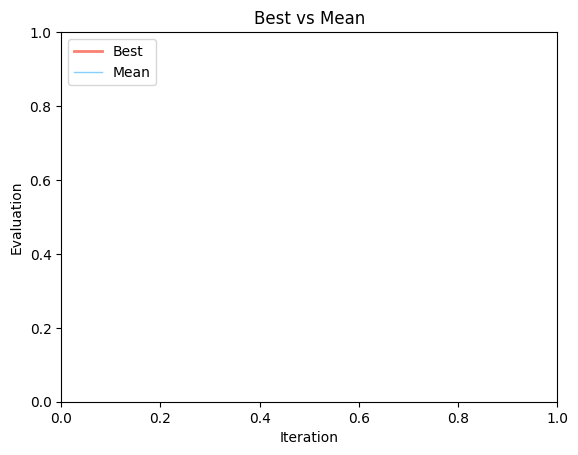

In [ ]:
import matplotlib.pyplot as plt

x_limit = len(avg_fitness_list) + len(avg_fitness_list)//50
y_limit_high = np.max(max_fitness_list)

plt.xlim(0, x_limit)
plt.ylim(0, y_limit_high)
plt.plot(max_fitness_list, linewidth=2, color="salmon")
plt.plot(avg_fitness_list, linewidth=1, color="lightskyblue")
plt.ylabel("Evaluation")
plt.xlabel("Iteration")
plt.legend(["Best", "Mean"], loc="upper left")
plt.title("Best vs Mean")
plt.show()